In [2]:
# Core libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Data processing and analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, asdict, field
import math
import matplotlib.pyplot as plt  # Add this for plotting



# Progress tracking and logging
from tqdm import tqdm
import logging

# Random seed
import random

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

In [3]:
from dataclasses import dataclass, field
from typing import Dict, List, Optional
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class DataConfig:
    seq_length: int = 3
    min_seq_length: int = 1
    start_season: int = 2016
    train_ratio: float = 0.7
    valid_ratio: float = 0.2
    batch_size: int = 32
    min_games: int = 30  # Changed from min_innings
    positions: List[str] = field(default_factory=lambda: ['1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH'])

@dataclass
class PositionalMetrics:
    inn: float
    drs: float
    uzr: float
    oaa: float
    is_primary: bool = False
    age: int = 0

@dataclass
class SeasonSnapshot:
    season: int
    age: int
    metrics: Dict[str, PositionalMetrics]
    is_padded: bool = False

@dataclass
class PlayerSequence:
    player_id: str
    history: List[SeasonSnapshot]
    target: Optional[SeasonSnapshot]
    history_mask: List[bool]
    gap_years: List[int] = field(default_factory=list)

class DataProcessor:
    def __init__(self, config: DataConfig):
        self.config = config
        self.min_age = 15
        self.max_age = 50
        self.scalers = {
            'Inn': StandardScaler(),
            'DRS': StandardScaler(),
            'UZR/150': StandardScaler(),
            'OAA': StandardScaler()
        }
    
    def normalize_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        # Normalize non-zero values only
        for metric in self.scalers:
            non_zero = df[metric] != 0
            if non_zero.any():
                self.scalers[metric].fit(df.loc[non_zero, [metric]])
                df.loc[non_zero, metric] = self.scalers[metric].transform(df.loc[non_zero, [metric]])
        return df
    def validate_metrics(self, fielding_df: pd.DataFrame) -> None:
        # Remove pitchers and catchers first
        df = fielding_df[~fielding_df['Pos'].isin(['P', 'C'])].copy()
        
        logger.info("\nMetric Availability Analysis:")
        logger.info(f"Total records after position filter: {len(df)}")
        
        # Check by year with complete data analysis
        logger.info("\nYearly Metric Completeness:")
        yearly_stats = df.groupby('Season').agg({
            'DRS': lambda x: x.isna().sum(),
            'UZR/150': lambda x: x.isna().sum(),
            'OAA': lambda x: x.isna().sum(),
            'IDfg': 'count'
        })
        
        # Add complete data analysis
        yearly_completeness = df.groupby('Season').apply(
            lambda x: pd.Series({
                'total_rows': len(x),
                'all_metrics': len(x[x['DRS'].notna() & x['UZR/150'].notna() & x['OAA'].notna()]),
                'drs_uzr': len(x[x['DRS'].notna() & x['UZR/150'].notna()]),
                'drs_oaa': len(x[x['DRS'].notna() & x['OAA'].notna()]),
                'uzr_oaa': len(x[x['UZR/150'].notna() & x['OAA'].notna()])
            })
        )
        
        # Calculate percentages
        yearly_completeness['all_metrics_pct'] = yearly_completeness['all_metrics'] / yearly_completeness['total_rows']
        yearly_completeness['drs_uzr_pct'] = yearly_completeness['drs_uzr'] / yearly_completeness['total_rows']
        yearly_completeness['drs_oaa_pct'] = yearly_completeness['drs_oaa'] / yearly_completeness['total_rows']
        yearly_completeness['uzr_oaa_pct'] = yearly_completeness['uzr_oaa'] / yearly_completeness['total_rows']
        
        logger.info("\nYearly Completeness Stats:")
        logger.info(yearly_completeness)
        
        # Check by position
        logger.info("\nMissing Metrics by Position:")
        pos_stats = df.groupby('Pos').agg({
            'DRS': lambda x: x.isna().sum(),
            'UZR/150': lambda x: x.isna().sum(),
            'OAA': lambda x: x.isna().sum(),
            'IDfg': 'count'
        })
        logger.info(pos_stats)

    def process_data(self, fielding_df: pd.DataFrame, batting_df: pd.DataFrame) -> pd.DataFrame:
        logger.info(f"Initial records: {len(fielding_df)}")
        
        # 1. Filter positions and years first
        fielding_df = fielding_df[
            (~fielding_df['Pos'].isin(['P', 'C'])) &
            (fielding_df['Season'] >= self.config.start_season)
        ].copy()
        
        # 2. Get valid batting seasons and merge
        valid_seasons = fielding_df[['IDfg', 'Season']].drop_duplicates()
        batting_data = batting_df[
            batting_df['Age'].notna()
        ][['IDfg', 'Season', 'Age', 'G']].merge(
            valid_seasons,
            on=['IDfg', 'Season'],
            how='inner'
        )
        
        # 3. Calculate fielding games totals
        fielding_totals = fielding_df.groupby(['IDfg', 'Season'])['G'].sum().reset_index()
        fielding_totals = fielding_totals.merge(
            batting_data,
            on=['IDfg', 'Season'],
            how='inner',
            suffixes=('_field', '') 
        )
        
        # 4. Create DH records - difference between total games and fielding games
        dh_records = fielding_totals[
            (fielding_totals['G'] - fielding_totals['G_field']) > 0  
        ].copy()
        dh_records['Pos'] = 'DH'
        dh_records['G'] = dh_records['G'] - dh_records['G_field']  # DH games
        dh_records['Inn'] = dh_records['G'] * 9  # Convert to innings for consistency
        dh_records[['DRS', 'UZR/150', 'OAA']] = 0
        
        # 5. Filter fielding data for metrics
        fielding_df = fielding_df[
            fielding_df['DRS'].notna() &
            fielding_df['UZR/150'].notna() &
            fielding_df['OAA'].notna()
        ]
        
        # 6. Combine fielding and DH records
        df = pd.concat([
            fielding_df.merge(batting_data[['IDfg', 'Season', 'Age']], on=['IDfg', 'Season']),
            dh_records[['IDfg', 'Season', 'Age', 'Pos', 'G', 'Inn', 'DRS', 'UZR/150', 'OAA']]
        ]).reset_index(drop=True)
        
        # Calculate percentages
        df['Inn_Pct'] = df.groupby(['IDfg', 'Season'])['Inn'].transform(
            lambda x: x / x.sum()
        ).fillna(0)
        
        logger.info(f"Final records: {len(df)}")
        logger.info(f"Unique players: {df['IDfg'].nunique()}")
        logger.info(f"Position distribution:\n{df['Pos'].value_counts(normalize=True)}")
        
        return df
    
    def create_sequences(self, df: pd.DataFrame) -> List[PlayerSequence]:
        sequences = []
        stats = {"players": 0, "valid_seasons": 0, "sequences": 0}
        
        for player_id, player_data in df.groupby('IDfg'):
            stats["players"] += 1
            seasons = []
            
            # Sort seasons chronologically
            for season, season_data in player_data.sort_values('Season').groupby('Season'):
                position_metrics = {}
                
                # Create position metrics for this season
                for _, row in season_data.iterrows():
                    position_metrics[row['Pos']] = PositionalMetrics(
                        inn=float(row['Inn']),
                        drs=float(row['DRS']),
                        uzr=float(row['UZR/150']),
                        oaa=float(row['OAA']),
                        age=int(row['Age']),
                        is_primary=(row['Inn'] == season_data['Inn'].max())
                    )
                
                seasons.append(SeasonSnapshot(
                    season=int(season),
                    age=int(season_data['Age'].iloc[0]),
                    metrics=position_metrics,
                    is_padded=False
                ))
                stats["valid_seasons"] += 1
            
            # Create sequences with padding
            if len(seasons) >= 2:  # Need at least 1 history + 1 target
                for i in range(len(seasons) - 1):
                    # Get available history
                    history = seasons[max(0, i-self.config.seq_length+1):i+1]
                    target = seasons[i+1]
                    
                    # Add padding if needed
                    pad_length = self.config.seq_length - len(history)
                    if pad_length > 0:
                        padding = [
                            SeasonSnapshot(
                                season=0,
                                age=history[0].age - 1,
                                metrics={},
                                is_padded=True
                            ) for _ in range(pad_length)
                        ]
                        history = padding + history
                    
                    sequences.append(PlayerSequence(
                        player_id=str(player_id),
                        history=history,
                        target=target,
                        history_mask=[not s.is_padded for s in history]
                    ))
                    stats["sequences"] += 1
        
        logger.info(f"\nSequence Creation Stats:")
        logger.info(f"Players processed: {stats['players']}")
        logger.info(f"Valid seasons: {stats['valid_seasons']}")
        logger.info(f"Sequences created: {stats['sequences']}")
        
        return sequences

class FieldingDataset(Dataset):
    def __init__(self, sequences: List[PlayerSequence], data_config: DataConfig):
        self.sequences = sequences
        self.data_config = data_config
        self.positions = data_config.positions
        
    def __len__(self) -> int:
        return len(self.sequences)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        sequence = self.sequences[idx]
        
        # Initialize tensors - Update to 5 features
        history = torch.zeros(self.data_config.seq_length, len(self.positions), 5)
        history_mask = torch.zeros(self.data_config.seq_length, len(self.positions))
        sequence_mask = torch.tensor([not s.is_padded for s in sequence.history])
        
        # Fill history tensors
        for t, season in enumerate(sequence.history):
            if not season.is_padded:
                for pos_idx, pos in enumerate(self.positions):
                    if pos in season.metrics:
                        metrics = season.metrics[pos]
                        history[t, pos_idx] = torch.tensor([
                            metrics.inn,
                            metrics.drs,
                            metrics.uzr,
                            metrics.oaa,
                            metrics.age  # Add age as fifth feature
                        ])
                        history_mask[t, pos_idx] = 1.0
        
        

        target_positions = torch.zeros(len(self.positions))
        target_mask = torch.zeros(len(self.positions))
        
        total_innings = sum(m.inn for m in sequence.target.metrics.values())
        for pos in sequence.target.metrics:
            pos_idx = self.positions.index(pos)
            target_positions[pos_idx] = sequence.target.metrics[pos].inn / total_innings
            target_mask[pos_idx] = 1.0
            
        return {
            'history': history,
            'history_mask': history_mask,
            'sequence_mask': sequence_mask,
            'target_positions': target_positions,
            'target_mask': target_mask
        }

# Initialize
config = DataConfig()
processor = DataProcessor(config)

# Load data
fielding_df = pd.read_csv('../data/mlb_fielding_data_2000_2024.csv')
batting_df = pd.read_csv('../data/mlb_batting_data_2000_2024.csv')

# Process data to get clean DataFrame
processed_df = processor.process_data(fielding_df, batting_df)

# Create sequences from processed data
sequences = processor.create_sequences(processed_df)
logger.info(f"Created {len(sequences)} sequences")

# Create train/valid/test splits
total_size = len(sequences)
train_size = int(total_size * config.train_ratio)
valid_size = int(total_size * config.valid_ratio)

train_sequences = sequences[:train_size]
valid_sequences = sequences[train_size:train_size + valid_size]
test_sequences = sequences[train_size + valid_size:]


INFO:__main__:Initial records: 50599
INFO:__main__:Final records: 14033
INFO:__main__:Unique players: 1421
INFO:__main__:Position distribution:
Pos
DH    0.255042
LF    0.143733
RF    0.131975
CF    0.101618
3B    0.101190
2B    0.097912
1B    0.090857
SS    0.077674
Name: proportion, dtype: float64
INFO:__main__:
Sequence Creation Stats:
INFO:__main__:Players processed: 1421
INFO:__main__:Valid seasons: 5031
INFO:__main__:Sequences created: 3610
INFO:__main__:Created 3610 sequences


In [4]:
print("\nPosition Distribution in Training Data:")
all_positions = []
for sequence in train_sequences:
    for season in sequence.history:
        if not season.is_padded:
            for pos in season.metrics.keys():
                all_positions.append(pos)
    
    # Also include target season positions
    for pos in sequence.target.metrics.keys():
        all_positions.append(pos)

pos_counts = pd.Series(all_positions).value_counts()
pos_dist = pos_counts / len(all_positions)

print(pos_dist)


Position Distribution in Training Data:
DH    0.254085
LF    0.136371
RF    0.129549
3B    0.101415
CF    0.101373
2B    0.097246
1B    0.096951
SS    0.083010
Name: count, dtype: float64


In [5]:
@dataclass
class DataConfig:
    seq_length: int = 3
    start_season: int = 2016
    train_ratio: float = 0.7
    valid_ratio: float = 0.2
    batch_size: int = 32
    min_innings: float = 50.0
    min_dh_games: int = 40
    positions: List[str] = field(default_factory=lambda: ['1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH'])

@dataclass
class ModelConfig:
    hidden_size: int = 128  # Base hidden dimension
    num_heads: int = 8
    lstm_layers: int = 2
    lstm_dropout: float = 0.1
    
@dataclass
class TrainingConfig:
    epochs: int = 50
    learning_rate: float = 0.001
    weight_decay: float = 0.01
    clip_grad_norm: float = 1.0
    patience: int = 5
    scheduler_factor: float = 0.5
    scheduler_patience: int = 2

@dataclass
class LossConfig:
    pos_weight_smoothing: float = 0.1
    min_weight: float = 0.5

Attention mechanism for positional predictor

In [6]:
class PositionAttention(nn.Module):
    def __init__(self, hidden_size: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert hidden_size % num_heads == 0
        self.hidden_size = hidden_size  # 256 (BiLSTM output)
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads  # 256/8 = 32
        
        # All projections: 256 -> 256
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)
        self.o_proj = nn.Linear(hidden_size, hidden_size)
        
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, num_pos, hidden_size = x.size()
        
        x_flat = x.contiguous().view(-1, hidden_size)

        
        # Project and reshape to [batch, seq, pos, heads, head_dim]
        # hidden_size (256) = num_heads (8) * head_dim (32)
        q = self.q_proj(x_flat).view(batch_size, seq_len, num_pos, self.num_heads, self.head_dim)
        k = self.k_proj(x_flat).view(batch_size, seq_len, num_pos, self.num_heads, self.head_dim)
        v = self.v_proj(x_flat).view(batch_size, seq_len, num_pos, self.num_heads, self.head_dim)
        
        # Multi-head attention
        q = q.transpose(2, 3)
        k = k.transpose(2, 3)
        v = v.transpose(2, 3)
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # Mask handling
        if mask is not None:
            attention_mask = mask.bool()
            attention_mask = attention_mask.unsqueeze(2).unsqueeze(-1)
            attention_mask = attention_mask.expand(-1, -1, self.num_heads, -1, -1)
            scores = scores.masked_fill(~attention_mask, -1e9)  # Changed from float('-inf')
        
        # Modified softmax with numerical stability
        scores_exp = torch.exp(scores - scores.max(dim=-1, keepdim=True)[0])
        scores_sum = scores_exp.sum(dim=-1, keepdim=True) + 1e-9
        attn = scores_exp / scores_sum
        attn = self.dropout(attn)
        
        out = torch.matmul(attn, v)
        out = out.transpose(2, 3).contiguous()
        out = out.view(batch_size, seq_len, num_pos, -1)
        
        return self.norm(x + self.o_proj(out.view(-1, self.num_heads * self.head_dim)).view(x.shape))


Define positional predictor model

In [7]:
class PositionPredictor(nn.Module):
    def __init__(self, data_config: DataConfig, model_config: ModelConfig, device: torch.device):
        super().__init__()
        self.device = device
        self.data_config = data_config  # Store config
        
        # Embeddings split hidden size
        self.metric_embed = nn.Linear(5, model_config.hidden_size // 2)
        self.pos_embed = nn.Embedding(len(data_config.positions), model_config.hidden_size // 2)
        
        # LSTM with full hidden size
        self.lstm = nn.LSTM(
            input_size=model_config.hidden_size * len(data_config.positions),
            hidden_size=model_config.hidden_size,
            num_layers=model_config.lstm_layers,
            dropout=model_config.lstm_dropout,
            bidirectional=True,
            batch_first=True
        )
        
        # Attention with bidirectional size
        self.attention = PositionAttention(
            hidden_size=model_config.hidden_size * 2,
            num_heads=model_config.num_heads,
            dropout=model_config.lstm_dropout
        )
        
        # Output
        self.position_classifier = nn.Sequential(
            nn.Linear(model_config.hidden_size * 2, model_config.hidden_size),
            nn.ReLU(),
            nn.Dropout(model_config.lstm_dropout),
            nn.Linear(model_config.hidden_size, len(data_config.positions))
        )
    
    def forward(self, history, history_mask, sequence_mask):
        batch_size, seq_len, num_pos, _ = history.size()

        
        # Embeddings
        metric_features = self.metric_embed(history)
        pos_idx = torch.arange(num_pos, device=self.device)
        pos_idx = pos_idx.expand(batch_size, seq_len, num_pos)
        pos_features = self.pos_embed(pos_idx)

        
        # Combine and flatten for LSTM
        features = torch.cat([metric_features, pos_features], dim=-1)
        features = features.view(batch_size, seq_len, -1)

        
        # LSTM
        lstm_out, _ = self.lstm(features)

        
        # Reshape for attention
        lstm_features = lstm_out.view(batch_size, seq_len, 1, -1).expand(-1, -1, num_pos, -1)

        
        # Apply attention
        attended = self.attention(lstm_features, history_mask)

        
        # After pooling
        mask_weights = sequence_mask.float().unsqueeze(-1).unsqueeze(-1)
        seq_pooled = (attended * mask_weights).sum(dim=1) / (mask_weights.sum(dim=1) + 1e-6)
        
        position_pooled = seq_pooled.mean(dim=-2)
        
        # Before softmax
        raw_logits = self.position_classifier(position_pooled)
        
        # Final classification
        position_logits = F.log_softmax(self.position_classifier(position_pooled), dim=-1)
        
        return position_logits

Define our custom loss function for defense

In [8]:
def calculate_position_weights(dataset: FieldingDataset, loss_config: LossConfig) -> torch.Tensor:
    """Calculate inverse frequency weights for positions"""
    position_counts = torch.zeros(len(dataset.positions))
    
    for seq in dataset.sequences:
        for season in seq.history:
            for pos in season.metrics.keys():
                pos_idx = dataset.positions.index(pos)
                position_counts[pos_idx] += 1
    
    # Smooth and normalize weights
    weights = 1.0 / (position_counts + loss_config.pos_weight_smoothing)
    weights = weights.clamp(min=loss_config.min_weight)
    return weights / weights.mean()


class PositionDistributionLoss(nn.Module):
    def __init__(self, smooth_factor: float = 0.1):
        super().__init__()
        self.smooth_factor = smooth_factor

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:

        # Normalize targets
        masked_targets = targets * mask
        targets_sum = masked_targets.sum(dim=-1, keepdim=True)
        normalized_targets = masked_targets / (targets_sum + 1e-8)
        
        # KL divergence
        loss = F.kl_div(
            predictions,
            normalized_targets,
            reduction='none',
            log_target=False
        )
        
        return (loss * mask).sum() / (mask.sum() + 1e-8)



Define training pipeline

In [9]:
class PositionTrainer:
    def __init__(self, 
                 model: PositionPredictor,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 training_config: TrainingConfig,
                 loss_config: LossConfig, 
                 device: torch.device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.training_config = training_config
        self.loss_config = loss_config
        self.device = device
        
        # Initialize distribution loss
        self.criterion = PositionDistributionLoss(smooth_factor=loss_config.pos_weight_smoothing)
        
        
        # Initialize optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=training_config.learning_rate,
            weight_decay=training_config.weight_decay
        )
        
        # Initialize scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=training_config.scheduler_factor,
            patience=training_config.scheduler_patience,
            verbose=True
        )
        
        # Initialize metrics
        self.train_losses = []
        self.val_losses = []
        self.position_f1 = defaultdict(list)
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        
    def save_checkpoint(self, filename: str):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'position_f1': self.position_f1,
        }, filename)

    def train(self):
        """Main training loop with early stopping"""
        for epoch in range(self.training_config.epochs):  # Fix here
            # Train epoch
            train_loss = self.train_epoch()
            self.train_losses.append(train_loss)
            
            # Validate
            val_loss = self.validate()
            self.val_losses.append(val_loss)
            
            # Scheduler step
            self.scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_checkpoint('best_model.pt')
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.training_config.patience:  # Fix here
                    logger.info(f"Early stopping at epoch {epoch}")
                    break
            
            # Log progress
            logger.info(
                f"Epoch {epoch}: "
                f"Train Loss = {train_loss:.4f}, "
                f"Val Loss = {val_loss:.4f}"
            )

    def train_epoch(self):
        self.model.train()
        epoch_loss = 0
        
        for batch_idx, batch in enumerate(self.train_loader):

            
            # Move batch to device
            batch = {k: v.to(self.device) for k, v in batch.items()}
            
            self.optimizer.zero_grad()
            predictions = self.model(
                batch['history'],
                batch['history_mask'],
                batch['sequence_mask']
            )
            

            
            # Calculate loss
            loss = self.criterion(
                predictions,
                batch['target_positions'].float(),
                batch['target_mask'].float()
            )
            
            # Backward pass
            loss.backward()
            
            
            torch.nn.utils.clip_grad_norm_(
                self.model.parameters(), 
                self.training_config.clip_grad_norm
            )
            self.optimizer.step()
            
            epoch_loss += loss.item()
            

        
        return epoch_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch in self.val_loader:
                # Move batch to device first
                batch = {k: v.to(self.device) for k, v in batch.items()}
                predictions = self.model(
                    batch['history'],
                    batch['history_mask'],
                    batch['sequence_mask']
                )
                
                loss = self.criterion(
                    predictions,
                    batch['target_positions'].float(),
                    batch['target_mask'].float()
                )
                
                val_loss += loss.item()
                all_preds.append(torch.sigmoid(predictions))
                all_targets.append(batch['target_positions'])
        
        # Calculate metrics
        val_loss = val_loss / len(self.val_loader)
        self.calculate_position_metrics(
            torch.cat(all_preds),
            torch.cat(all_targets)
        )
        
        return val_loss
    

    def calculate_position_metrics(self, predictions: torch.Tensor, 
                                targets: torch.Tensor) -> Dict[str, float]:
        """Calculate per-position performance metrics"""
        metrics = {}
        predictions = (predictions > 0.5).float()
        

        
        for i, pos in enumerate(self.model.data_config.positions):
           
            # Calculate metrics per position
            true_pos = ((predictions[:, i] == 1) & (targets[:, i] == 1)).sum()
            false_pos = ((predictions[:, i] == 1) & (targets[:, i] == 0)).sum()
            false_neg = ((predictions[:, i] == 0) & (targets[:, i] == 1)).sum()
            
            # F1 score
            precision = true_pos / (true_pos + false_pos + 1e-6)
            recall = true_pos / (true_pos + false_neg + 1e-6)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
            
            metrics[f"{pos}_f1"] = f1.item()
            self.position_f1[pos].append(f1.item())
        
        return metrics

    def plot_metrics(self):
        """Plot training metrics"""
        plt.figure(figsize=(12, 4))
        
        # Loss curves
        plt.subplot(121)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Position F1 scores
        plt.subplot(122)
        for pos in self.position_f1:
            plt.plot(self.position_f1[pos], label=pos)
        plt.title('Position F1 Scores')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()

Train model

INFO:__main__:Starting training...
INFO:__main__:Epoch 0: Train Loss = 0.2385, Val Loss = 0.2631
INFO:__main__:Epoch 1: Train Loss = 0.2080, Val Loss = 0.2473
INFO:__main__:Epoch 2: Train Loss = 0.2043, Val Loss = 0.2512
INFO:__main__:Epoch 3: Train Loss = 0.1970, Val Loss = 0.2615
INFO:__main__:Epoch 4: Train Loss = 0.1947, Val Loss = 0.2512


Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.


INFO:__main__:Epoch 5: Train Loss = 0.1822, Val Loss = 0.2398
INFO:__main__:Epoch 6: Train Loss = 0.1771, Val Loss = 0.2452
INFO:__main__:Epoch 7: Train Loss = 0.1732, Val Loss = 0.2382
INFO:__main__:Epoch 8: Train Loss = 0.1701, Val Loss = 0.2424
INFO:__main__:Epoch 9: Train Loss = 0.1684, Val Loss = 0.2497
INFO:__main__:Epoch 10: Train Loss = 0.1698, Val Loss = 0.2490


Epoch 00011: reducing learning rate of group 0 to 2.5000e-04.


INFO:__main__:Epoch 11: Train Loss = 0.1607, Val Loss = 0.2456
INFO:__main__:Early stopping at epoch 12


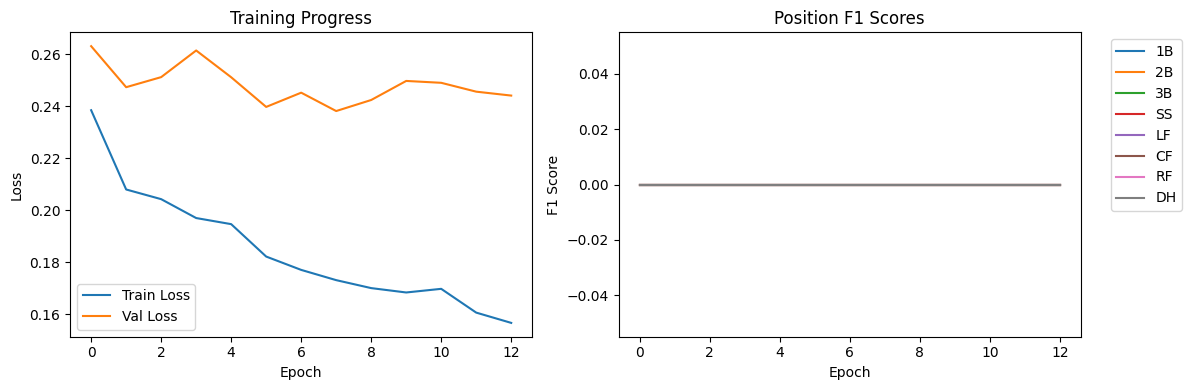

INFO:__main__:Training completed!


In [10]:
# Initialize configs
data_config = DataConfig()
model_config = ModelConfig()
training_config = TrainingConfig()
loss_config = LossConfig()

# Create datasets with data_config
train_dataset = FieldingDataset(train_sequences, data_config)
valid_dataset = FieldingDataset(valid_sequences, data_config)
test_dataset = FieldingDataset(test_sequences, data_config)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=data_config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=data_config.batch_size)
test_loader = DataLoader(test_dataset, batch_size=data_config.batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PositionPredictor(data_config, model_config, device).to(device)



# Create trainer with all configs
trainer = PositionTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    training_config=training_config,
    loss_config=loss_config,
    device=device
)


# Train model
logger.info("Starting training...")
trainer.train()

# Plot training metrics
trainer.plot_metrics()

# Save best model
torch.save({
    'model_state_dict': model.state_dict(),
    'data_config': data_config,
    'model_config': model_config,
}, 'position_predictor.pt')

logger.info("Training completed!")

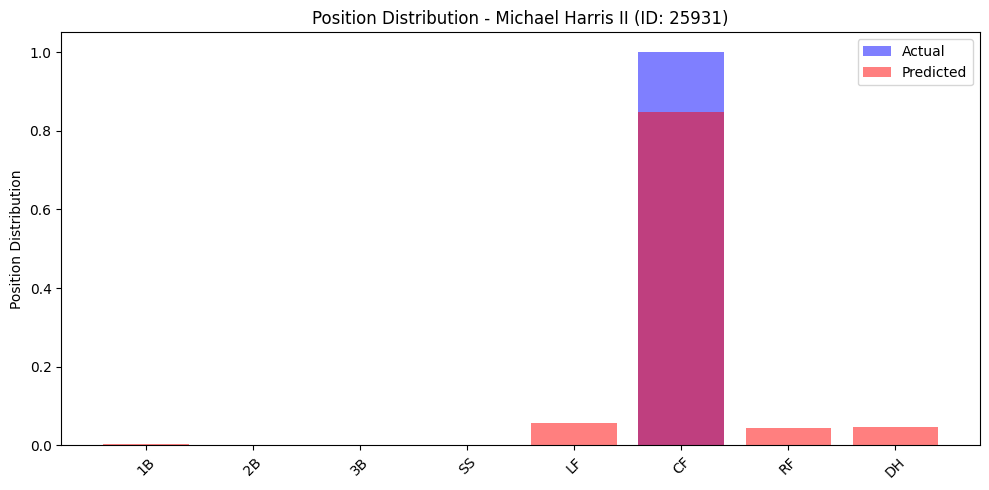


Player: Michael Harris II (ID: 25931)

History:

Season 0: No data

Season 0: No data

Season 2022 (Age 21):
CF: 1021 innings (100.0%)

Target Season (Age 22):

Actual distribution:
CF: 100.0%

Predicted distribution:
LF: 5.7%
CF: 84.7%
RF: 4.4%
DH: 4.7%
--------------------------------------------------


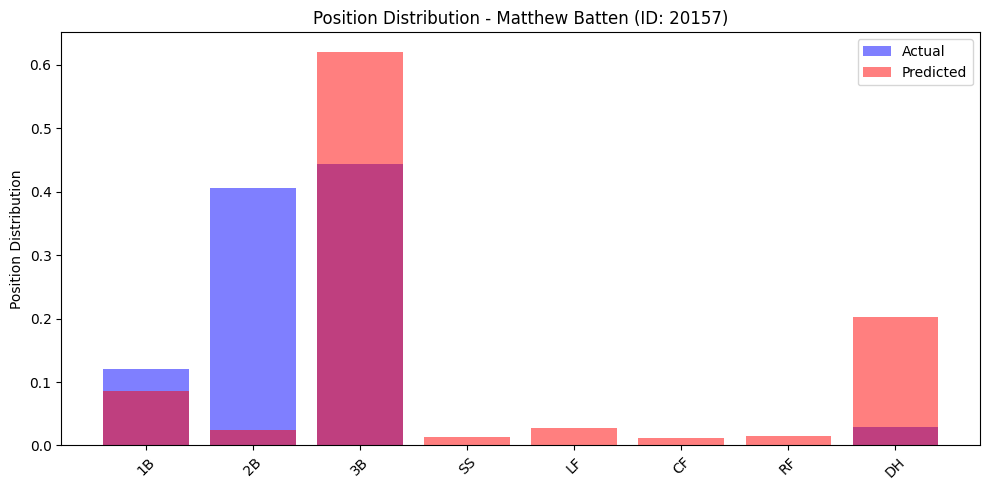


Player: Matthew Batten (ID: 20157)

History:

Season 0: No data

Season 0: No data

Season 2022 (Age 27):
3B: 31 innings (56.4%)
LF: 6 innings (10.9%)
DH: 18 innings (32.7%)

Target Season (Age 28):

Actual distribution:
1B: 12.1%
2B: 40.6%
3B: 44.4%
DH: 2.9%

Predicted distribution:
1B: 8.5%
2B: 2.4%
3B: 62.0%
SS: 1.4%
LF: 2.8%
CF: 1.2%
RF: 1.5%
DH: 20.2%
--------------------------------------------------


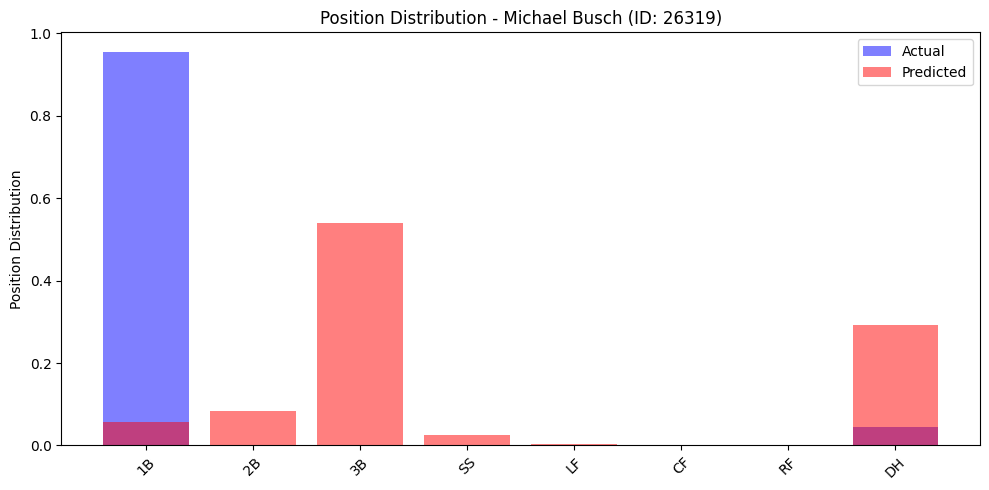


Player: Michael Busch (ID: 26319)

History:

Season 0: No data

Season 0: No data

Season 2023 (Age 25):
2B: 9 innings (5.0%)
3B: 99 innings (55.0%)
DH: 72 innings (40.0%)

Target Season (Age 26):

Actual distribution:
1B: 95.4%
DH: 4.6%

Predicted distribution:
1B: 5.6%
2B: 8.3%
3B: 54.0%
SS: 2.5%
DH: 29.2%
--------------------------------------------------


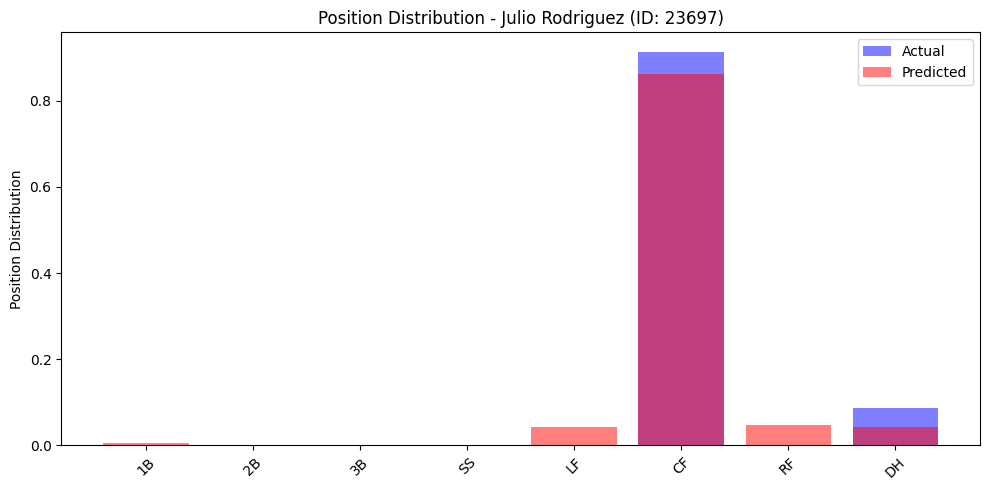


Player: Julio Rodriguez (ID: 23697)

History:

Season 0: No data

Season 2022 (Age 21):
CF: 1126 innings (98.4%)
DH: 18 innings (1.6%)

Season 2023 (Age 22):
CF: 1342 innings (98.0%)
DH: 27 innings (2.0%)

Target Season (Age 23):

Actual distribution:
CF: 91.3%
DH: 8.7%

Predicted distribution:
LF: 4.2%
CF: 86.3%
RF: 4.6%
DH: 4.2%
--------------------------------------------------


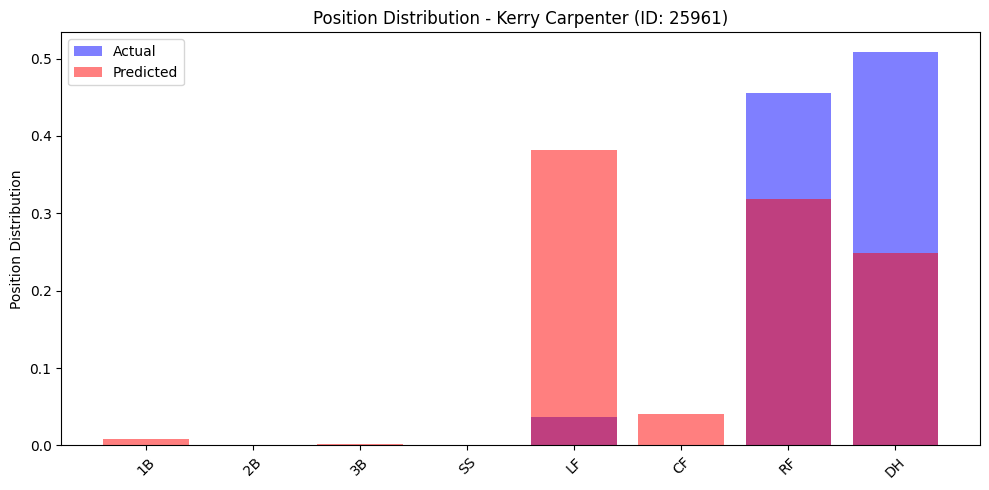


Player: Kerry Carpenter (ID: 25961)

History:

Season 0: No data

Season 2022 (Age 24):
LF: 89 innings (35.7%)
RF: 61 innings (24.5%)
DH: 99 innings (39.8%)

Season 2023 (Age 25):
LF: 72 innings (7.5%)
RF: 651 innings (67.4%)
DH: 243 innings (25.2%)

Target Season (Age 26):

Actual distribution:
LF: 3.6%
RF: 45.5%
DH: 50.9%

Predicted distribution:
LF: 38.2%
CF: 4.0%
RF: 31.8%
DH: 24.8%
--------------------------------------------------


In [11]:
# Create test dataset
test_dataset = FieldingDataset(test_sequences, data_config)

def visualize_predictions(model, test_data, num_samples=5):
    """
    Visualize predictions vs actual position distributions
    
    Args:
        model: trained PositionPredictor model
        test_data: FieldingDataset object
        num_samples: number of samples to visualize
    """
    model.eval()
    
    # Create player name lookup
    batter_df = pd.read_csv('../data/mlb_batting_data_2000_2024.csv')
    name_lookup = dict(zip(batter_df['IDfg'], batter_df['Name']))
    
    # Random samples
    indices = torch.randperm(len(test_data))[:num_samples]
    
    for idx in indices:
        sample = test_data[idx]
        sequence = test_data.sequences[idx]
        player_name = name_lookup.get(int(sequence.player_id), "Unknown")
        
        
        # Move to device
        batch = {k: v.unsqueeze(0).to(model.device) for k, v in sample.items()}
        
        # Get predictions
        with torch.no_grad():
            pred_logits = model(
                batch['history'],
                batch['history_mask'],
                batch['sequence_mask']
            )
            pred_probs = torch.exp(pred_logits)
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 5))
        positions = test_data.positions
        x = range(len(positions))
        
        # Actual vs Predicted
        ax.bar(x, batch['target_positions'][0].cpu(), alpha=0.5, label='Actual', color='blue')
        ax.bar(x, pred_probs[0].cpu(), alpha=0.5, label='Predicted', color='red')
        
        ax.set_xticks(x)
        ax.set_xticklabels(positions, rotation=45)
        ax.set_ylabel('Position Distribution')
        ax.set_title(f'Position Distribution - {player_name} (ID: {sequence.player_id})')
        
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print distributions
        print(f"\nPlayer: {player_name} (ID: {sequence.player_id})")
        
        print("\nHistory:")
        for season in sequence.history:
            if not season.is_padded and season.metrics:  # Check if season has metrics
                # Get age from any position's metrics
                age = next(iter(season.metrics.values())).age
                print(f"\nSeason {season.season} (Age {age}):")
                total_inn = sum(m.inn for m in season.metrics.values())
                for pos, metrics in season.metrics.items():
                    pct = metrics.inn / total_inn if total_inn > 0 else 0
                    print(f"{pos}: {metrics.inn:.0f} innings ({pct:.1%})")
            else:
                print(f"\nSeason {season.season}: No data")
        
        # Add age for target season
        if sequence.target.metrics:
            target_age = next(iter(sequence.target.metrics.values())).age
            print(f"\nTarget Season (Age {target_age}):")
        
        
        print("\nActual distribution:")
        for pos, prob in zip(positions, batch['target_positions'][0].cpu()):
            if prob > 0:
                print(f"{pos}: {prob:.1%}")
                
        print("\nPredicted distribution:")
        for pos, prob in zip(positions, pred_probs[0].cpu()):
            if prob > 0.01:
                print(f"{pos}: {prob:.1%}")
        
        print("-" * 50)

# Test
visualize_predictions(model, test_dataset)

In [13]:
# Load predictions (2025-2039) 
years = range(2025, 2040)
fielding_predictions = {}

for year in years:
    filepath = f"../data/generated/fielding_predictions_{year}.csv"
    fielding_predictions[year] = pd.read_csv(filepath)


# Calculate position percentages using IDfg
df_2025 = fielding_predictions[2025].copy()
df_2025['TotalInn'] = df_2025.groupby('IDfg')['Inn'].transform('sum')
df_2025['InnPct'] = df_2025['Inn'] / df_2025['TotalInn']

# Identify utility players
utility_mask = ~df_2025.groupby('IDfg')['InnPct'].transform(max).gt(0.8)
utility_ids = df_2025[utility_mask]['IDfg'].unique()

# Create filtered dataset
utility_data = {
    year: df[df['IDfg'].isin(utility_ids)] 
    for year, df in fielding_predictions.items()
}

# Display sample (with both IDfg and Name)
sample_display = df_2025[df_2025['IDfg'].isin(utility_ids[:5])].pivot_table(
    index=['IDfg', 'Name'],
    columns='Pos',
    values='InnPct',
    fill_value=0
).round(3)

print(f"Found {len(utility_ids)} utility players")
print("\nSample utility player position distributions:")
print(sample_display)

Found 197 utility players

Sample utility player position distributions:
Pos                     1B     2B     3B     SS
IDfg  Name                                     
7802  Miguel Rojas   0.000  0.277  0.286  0.437
19734 Josh Rojas     0.000  0.384  0.616  0.000
21479 Nico Hoerner   0.000  0.577  0.000  0.423
21618 Alec Bohm      0.369  0.000  0.631  0.000
22715 Maikel Garcia  0.000  0.510  0.490  0.000


C:\Users\User\AppData\Local\Temp\ipykernel_23928\2206242363.py:16: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  utility_mask = ~df_2025.groupby('IDfg')['InnPct'].transform(max).gt(0.8)
